# Introduction

In this notebook, we will introduce and explain the implementation of [Neural Collaborative Filtering](https://arxiv.org/pdf/1708.05031.pdf) and study its performance. As you know from the demo session, Collaborative Filtering (CF) is one of the major recommendation approaches that allows for inclusion of information from other users or items in prediction of a user’s preference toward an item. What CF basically does is identifying patterns and similarities among users or items to make recommendation. CF has shown to be extremely powerful and in real-world projects different variants of CF have been widely exploited and shown outstanding performance. 

As deep neural architectures attracted a lot of attention by showing remarkable performance in various tasks such as computer vision, Natural Language Processing, etc. in the second decade of the century, researchers in recommendation area sought for methods to incorporate their power in recommendation as well. Neural CF paper is probably one of the most well-known works in this realm that tried to incorporate neural networks into CF. They high level idea of Neural CF is that an inner product between latent features of user and item features that were learnt using linear transformations of the data might be insufficient for capturing possibly complex underlying structure of the user behaviours. Therefore, this work tries to “*supercharge  the CF framework with non-linearities by leveraging a multi-layer perceptron to learn the user-item interaction function*”. We encourage you to have a  look at the [original paper](https://arxiv.org/pdf/1708.05031.pdf) that was presented in WWW 2017.

 We will finish this introduction with two final notes about the Neural CF. First, after we formally introduce the network’s structure, you can easily convince yourself that if you remove the non-linear activations from the neural network, you will re-obtain the original linear Matrix Factorization. Please take a moment and think about it! Second, although at the time, Neural CF attracted substantial attention and the paper’s results showed progress over the existing methodologies in top N recommendation, [a paper](https://colab.research.google.com/drive/1ih44InL4F_SJf7OU4YKovlrXtYlZ6_0e#scrollTo=TYY8R743PTKH&line=2&uniqifier=1) in RecSys 19 scrutinized the performance of neural recommendation approaches and we encourage you to have a look at it as well.  

# Problem Statement

Let's first define the problem that We are dealing with. Consider a set of users $U$ such that $|U|=M$, a set of items $I$ such that $|I|=N$, and a set of historical interactions between some of the users and the items $Y \in \mathbb{R}^{M \times N}$. This paper focuses on implicit feedback which indirectly reflects users’ preference through behaviours like watching videos, purchasing products and clicking items. Compared to explicit feedback (i.e., ratings and reviews), implicit feedback can be tracked automatically and is thus much easier to collect for content providers. However, it is more challenging to utilize, since user satisfaction is not observed and there is a natural scarcity of negative feedback. Denoting a user-item interaction record $y_{ui} \in Y$ to be the record of implicit feedback of user $u$ toward item $i$, $y_{ui}=1$ if the user has interacted with the item and otherwise $y_{ui}=0$. Note that since the feedback is implicit, we have no information on whether the user had a positive preference toward the item and whether she liked it or not. Hence, the implicit feedback is inherently a very noisy evidenced about the user’s preferences. 

Eventually, the recommendation problem is to estimate the scores of unobserved entries in $Y$, and use them to make recommendations. Formally speaking, the task is to obtain the values $\hat{y}_{ui}=f(u,i|\theta)$ where $\hat{y}_{ui}$ are the predicted scores for interaction between the user and item, $f$ is an interaction function that maps the model parameters $\theta$ to the predicted score. As in other Machine Learning problems, parameters $\theta$ are learnt by minimizing a proper loss function. This work focuses on two types of loss functions that are widely used in recommendation research:

**1- Pointwise loss**: Using point wise loss, the problem is formulated as a regression task in which the objective is to  minimize the squared error between predicted score \hat{y}_(u,i) and target value y(u,i). The problem that arises is that there are several unobserved instances in the user preference matrix that we have to deal with and obtain errors for such records. Often, the proposed workaround is to treat all the unobserved interactions equivalent to negative feedback and replacing them with a value of zero to be able to solve the optimization problem. You can easily convince yourself that this assumption is too severe because a lack of interaction does not necessarily imply lack of interest. In implementation, since the set of unobserved interactions often has a much larger cardinality than the observed ones, often a subset of them is sampled and used as the negative records. This approach is called "Negative Sampling".

**2- Pairwise loss:** In order to deal with the aforementioned issue in a more intelligent way, pairwise loss tries to rank observed entries higher than the unobserved instances. This task is performed by maximizing the margin between the observed instances and the unobserved ones. 

Neural CF parametrizes the interaction function using a neural network and optimizes the network parameters using either one of these losses. In this notebook, we use pointwise loss.



In the following sections, we will define the Neural CF architecture and its components. A majority of the code used in this notebook is obtained from [here](https://github.com/pyy0715/Neural-Collaborative-Filtering/tree/master). Now, first, let's install and import the required packages.

In [ ]:
!pip install -q tensorboardX


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 2.5 MB/s eta 0:00:00


In [ ]:
import os
import time
import random
import argparse
import numpy as np 
import pandas as pd 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from tensorboardX import SummaryWriter

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [ ]:
##Importing the data file from google drive

from google.colab import drive
drive.mount('/content/drive/')          # this will direct you to a link where you can get anmhkk authorization key
import sys
sys.path.append('/content/drive/My Drive/')
##Changing the working directory

%cd '/content/drive/My Drive/'


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive


In [ ]:
%cd VectorProject/


/content/drive/My Drive/VectorProject


In [ ]:
ls

LFM_ratings.txt  ML_ratings.txt  u.data


In [ ]:
ml = pd.read_csv(
	'u.data', 
	sep="\t", 
	names = ['user_id', 'item_id', 'rating', 'timestamp'], 
	engine='python')
ml

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


In [ ]:
# set the num_users, items
num_users = ml['user_id'].nunique()+1
num_items = ml['item_id'].nunique()+1

In [ ]:
class Rating_Datset(torch.utils.data.Dataset):
	def __init__(self, user_list, item_list, rating_list):
		super(Rating_Datset, self).__init__()
		self.user_list = user_list
		self.item_list = item_list
		self.rating_list = rating_list

	def __len__(self):
		return len(self.user_list)

	def __getitem__(self, idx):
		user = self.user_list[idx]
		item = self.item_list[idx]
		rating = self.rating_list[idx]
		
		return (
			torch.tensor(user, dtype=torch.long),
			torch.tensor(item, dtype=torch.long),
			torch.tensor(rating, dtype=torch.float)
			)

In [ ]:
class NCF_Data(object):
	"""
	Construct Dataset for NCF
	"""
	def __init__(self, config, ratings):
		self.ratings = ratings
		self.num_ng = config["num_ng"]
		self.num_ng_test = config["num_ng_test"]
		self.batch_size = config["batch_size"]

		self.preprocess_ratings = self._reindex(self.ratings)

		self.user_pool = set(self.ratings['user_id'].unique())
		self.item_pool = set(self.ratings['item_id'].unique())

		self.train_ratings, self.test_ratings = self._leave_one_out(self.preprocess_ratings)
		self.negatives = self._negative_sampling(self.preprocess_ratings)
		random.seed(config["seed"])
	
	def _reindex(self, ratings):
		"""
		Process dataset to reindex userID and itemID, also set rating as binary feedback
		"""
		user_list = list(ratings['user_id'].drop_duplicates())
		user2id = {w: i for i, w in enumerate(user_list)}

		item_list = list(ratings['item_id'].drop_duplicates())
		item2id = {w: i for i, w in enumerate(item_list)}

		ratings['user_id'] = ratings['user_id'].apply(lambda x: user2id[x])
		ratings['item_id'] = ratings['item_id'].apply(lambda x: item2id[x])
		ratings['rating'] = ratings['rating'].apply(lambda x: float(x > 0))
		return ratings

	def _leave_one_out(self, ratings):
		"""
		leave-one-out evaluation protocol in paper Bayer et al. WWW 2017
		For each user, we hold-out her latest interaction as the test
		set and utilized the remaining data for training.
		"""
		# find the latest interaction using the timestamps
		ratings['rank_latest'] = ratings.groupby(['user_id'])['timestamp'].rank(method='first', ascending=False)
		# the last interaction is held out for test
		test = ratings.loc[ratings['rank_latest'] == 1]
		# other interations will be used for training
		train = ratings.loc[ratings['rank_latest'] > 1]
		# verify the number of users in the test and train sets are equal
		assert train['user_id'].nunique()==test['user_id'].nunique(), 'Not Match Train User with Test User'
		return train[['user_id', 'item_id', 'rating']], test[['user_id', 'item_id', 'rating']]

	def _negative_sampling(self, ratings):
		#groups the item IDs per user and converts them into sets, eliminating duplicates, resetting the index, then renaming the column
		interact_status = (
			ratings.groupby('user_id')['item_id']
			.apply(set)
			.reset_index()
			.rename(columns={'item_id': 'interacted_items'}))

		interact_status['negative_items'] = interact_status['interacted_items'].apply(lambda x: self.item_pool - x)
		interact_status['negative_samples'] = interact_status['negative_items'].apply(lambda x: random.sample(x, self.num_ng_test))
		return interact_status[['user_id', 'negative_items', 'negative_samples']]

	def get_train_instance(self):
		"combines positive ratings with randomly sampled negative items for each user and constructs the user-item-rating data"
		users, items, ratings = [], [], []
		train_ratings = pd.merge(self.train_ratings, self.negatives[['user_id', 'negative_items']], on='user_id')
		train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, self.num_ng))
		for row in train_ratings.itertuples():
			users.append(int(row.user_id))
			items.append(int(row.item_id))
			ratings.append(float(row.rating))
			for i in range(self.num_ng):
				users.append(int(row.user_id))
				items.append(int(row.negatives[i]))
				ratings.append(float(0))  # negative samples get 0 rating
		dataset = Rating_Datset(
			user_list=users,
			item_list=items,
			rating_list=ratings)
		return torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, shuffle=True, num_workers=4)

	def get_test_instance(self):
		"does the same for the test set"
		users, items, ratings = [], [], []
		test_ratings = pd.merge(self.test_ratings, self.negatives[['user_id', 'negative_samples']], on='user_id')
		for row in test_ratings.itertuples():
			users.append(int(row.user_id))
			items.append(int(row.item_id))
			ratings.append(float(row.rating))
			for i in getattr(row, 'negative_samples'):
				users.append(int(row.user_id))
				items.append(int(i))
				ratings.append(float(0))
		dataset = Rating_Datset(
			user_list=users,
			item_list=items,
			rating_list=ratings)
		return torch.utils.data.DataLoader(dataset, batch_size=self.num_ng_test+1, shuffle=False, num_workers=2)

Here, we define the evaluation metrics that can be used to assess how well the network is doing.

In [ ]:
def hit(ng_item, pred_items):
	if ng_item in pred_items:
		return 1
	return 0


def ndcg(ng_item, pred_items):
	if ng_item in pred_items:
		index = pred_items.index(ng_item)
		return np.reciprocal(np.log2(index+2))
	return 0


def metrics(model, test_loader, top_k, device):
	HR, NDCG = [], []

	for user, item, label in test_loader:
		user = user.to(device)
		item = item.to(device)

		predictions = model(user, item)
		_, indices = torch.topk(predictions, top_k)
		recommends = torch.take(
				item, indices).cpu().numpy().tolist()

		ng_item = item[0].item() # leave one-out evaluation has only one item per user
		HR.append(hit(ng_item, recommends))
		NDCG.append(ndcg(ng_item, recommends))

	return np.mean(HR), np.mean(NDCG)

**Neural MF Architecture**:
Neural Collaborative filtering has two major components:
1. GMF: This component is basically like the vanilla MF model that you are already familiar with. GMF applies a linear kernel to model user-item interactions.
2. MLP: This component is a Multi-layer Perceptron neural network that has non-linear activation functions used to model the nonlinearities in user-item interactions.
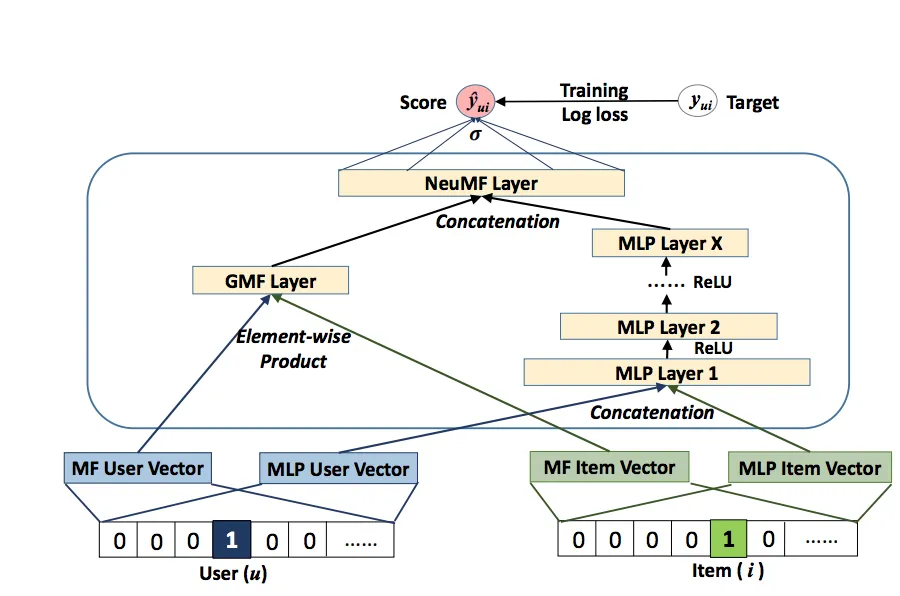
By combining these two components, Neural CF tries to obtain a proper estimation of the user-item interaction records. Each of the two components has its own trainable embedding layer that is optimized independently from the other layer’s embeddings. The input to the GMF component is the element-wize product of the user and item embeddings, but the input to the MLP are their concatenation. Finally, the output of the two networks are concatenated and input to a final layer that will output the logic representing the likelihood of presence of an interaction between the user and the item. These logits are converted to legitimate probabilities by applying a final activation in the original paper. In the following cells, we implement each of the components, and run the model optimization to train the model. 

Also, note that in the original implementation of the paper, first GMF and MLP components are pre-trained and then used as an initialization for the whole network, but this is skipped in this implementation. You can easily perform this using this code. 


In [ ]:
class NeuMF(nn.Module):
    def __init__(self, config, num_users, num_items):
        super(NeuMF, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.factor_num_mf = config["factor_num"]
        self.factor_num_mlp =  int(config["layers"][0]/2)
        self.layers = config["layers"]

        self.embedding_user_mlp = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.factor_num_mlp)
        self.embedding_item_mlp = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.factor_num_mlp)

        self.embedding_user_mf = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.factor_num_mf)
        self.embedding_item_mf = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.factor_num_mf)

        self.fc_layers = nn.ModuleList()
        for idx, (in_size, out_size) in enumerate(zip(config["layers"][:-1], config["layers"][1:])):
            self.fc_layers.append(torch.nn.Linear(in_size, out_size))
            self.fc_layers.append(nn.ReLU())

        self.affine_output = nn.Linear(in_features=config["layers"][-1] + self.factor_num_mf, out_features=1)
        self.logistic = nn.Sigmoid()
        self.init_weight()

    def init_weight(self):
      "initializing the weights as a unit normal. You can think of more advanced ways for initialization, but this is what the original paper does."
        nn.init.normal_(self.embedding_user_mlp.weight, std=0.01)
        nn.init.normal_(self.embedding_item_mlp.weight, std=0.01)
        nn.init.normal_(self.embedding_user_mf.weight, std=0.01)
        nn.init.normal_(self.embedding_item_mf.weight, std=0.01)
        
        for m in self.fc_layers:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                
        nn.init.xavier_uniform_(self.affine_output.weight)

        for m in self.modules():
            if isinstance(m, nn.Linear) and m.bias is not None:
                m.bias.data.zero_()

    def forward(self, user_indices, item_indices):
        user_embedding_mlp = self.embedding_user_mlp(user_indices)
        item_embedding_mlp = self.embedding_item_mlp(item_indices)

        user_embedding_mf = self.embedding_user_mf(user_indices)
        item_embedding_mf = self.embedding_item_mf(item_indices)

        mlp_vector = torch.cat([user_embedding_mlp, item_embedding_mlp], dim=-1)
        mf_vector =torch.mul(user_embedding_mf, item_embedding_mf)

        for idx, _ in enumerate(range(len(self.fc_layers))):
            mlp_vector = self.fc_layers[idx](mlp_vector)

        vector = torch.cat([mlp_vector, mf_vector], dim=-1)
        logits = self.affine_output(vector)
        rating = self.logistic(logits)
        return rating.squeeze()

In [ ]:
# model hyperparameters 
config={
    "seed" :98,
    "lr":0.001,
    "epochs": 5,
    "batch_size":2048,
    "top_k": 3,
    "num_ng":4,
    "num_ng_test":10,
    "factor_num":32,
    "layers":[64,32,16,8],

}



device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
writer = SummaryWriter()

# seed for Reproducibility
seed_everything(config["seed"])



# construct the train and test datasets
data = NCF_Data(config, ml)
train_loader = data.get_train_instance()
test_loader = data.get_test_instance()

# set model and loss, optimizer
model = NeuMF(config, num_users, num_items)
model = model.to(device)
loss_function = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=config["lr"])

# train, evaluation
best_hr = 0
for epoch in range(1, config["epochs"]+1):
	model.train() # Enable dropout (if have).
	start_time = time.time()

	for user, item, label in train_loader:
		user = user.to(device)
		item = item.to(device)
		label = label.to(device)

		optimizer.zero_grad()
		prediction = model(user, item)
		loss = loss_function(prediction, label)
		loss.backward()
		optimizer.step()
		writer.add_scalar('loss/Train_loss', loss.item(), epoch)
  



	model.eval()
	HR, NDCG = metrics(model, test_loader, config["top_k"], device)
	writer.add_scalar('Perfomance/HR@10', HR, epoch)
	writer.add_scalar('Perfomance/NDCG@10', NDCG, epoch)

	elapsed_time = time.time() - start_time
	print("The time elapse of epoch {:03d}".format(epoch) + " is: " + 
			time.strftime("%H: %M: %S", time.gmtime(elapsed_time)))
	print("HR: {:.3f}\tNDCG: {:.3f}".format(np.mean(HR), np.mean(NDCG)))

	if HR > best_hr:
		best_hr, best_ndcg, best_epoch = HR, NDCG, epoch
		torch.save(model,'model.pt')

writer.close()

<ipython-input-17-2e3bd90031b5>:52: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  interact_status['negative_samples'] = interact_status['negative_items'].apply(lambda x: random.sample(x, self.num_ng_test))
<ipython-input-17-2e3bd90031b5>:58: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, self.num_ng))
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warn

The time elapse of epoch 001 is: 00: 00: 16
HR: 0.662	NDCG: 0.527
The time elapse of epoch 002 is: 00: 00: 16
HR: 0.725	NDCG: 0.600
The time elapse of epoch 003 is: 00: 00: 16
HR: 0.771	NDCG: 0.634
The time elapse of epoch 004 is: 00: 00: 16
HR: 0.787	NDCG: 0.649
The time elapse of epoch 005 is: 00: 00: 16
HR: 0.793	NDCG: 0.658
